In [1]:
#load simulation data with loadSimDataOneHot
from simDataPreprocessing import loadSimDataOneHot

data, labels = loadSimDataOneHot('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/experimentalConditions', maxNumSequences=50000, splittingProbability=3/100, readSize=23)

first round prot1 done
first round prot6 done
first round prot15 done
first round prot 30 done


In [2]:
data.shape, labels.shape

((1489034, 402), (1489034, 1))

In [3]:
#split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1340130, 402), (148904, 402), (1340130, 1), (148904, 1))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:
#load data into torch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [7]:
#load data into torch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [27]:
#set model parameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 5
lambda_l2 = 0.001
size_factor_hidden = 20
bottle_neck_factor = 1/size_factor_hidden

In [28]:
#load data into torch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
#set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
#set input and output dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [31]:
#define 4 layer neural network with relu activation function and sigmoid output
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #first layer with input_dim input neurons and inputdim*size_factor_hidden output neurons
        self.fc1 = nn.Linear(input_dim, input_dim*size_factor_hidden)
        #second layer with inputdim*size_factor_hidden input neurons and inputdim*size_factor_hidden output neurons
        self.fc2 = nn.Linear(input_dim*size_factor_hidden, input_dim*size_factor_hidden)
        #third layer with inputdim*size_factor_hidden input neurons and inputdim output neurons
        self.fc3 = nn.Linear(input_dim*size_factor_hidden, int(input_dim*size_factor_hidden*bottle_neck_factor))
        #fourth layer with inputdim input neurons and output_dim output neurons
        self.fc4 = nn.Linear(int(input_dim*size_factor_hidden*bottle_neck_factor), output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x



In [32]:
#initialize model
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=402, out_features=8040, bias=True)
  (fc2): Linear(in_features=8040, out_features=8040, bias=True)
  (fc3): Linear(in_features=8040, out_features=402, bias=True)
  (fc4): Linear(in_features=402, out_features=1, bias=True)
)

In [33]:
#set loss function and adam optimizer with l2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [34]:
#import tqdm notebook for progress bar
from tqdm import tqdm

In [35]:
#train model on gpu and track training and test loss
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    train_loss = 0
    test_loss = 0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))
    model.eval()
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))

Epoch 1/5


100%|██████████| 2327/2327 [00:05<00:00, 389.90it/s]


Epoch 2/5


100%|██████████| 2327/2327 [00:07<00:00, 327.56it/s]


Epoch 3/5


100%|██████████| 2327/2327 [00:07<00:00, 324.49it/s]


Epoch 4/5


100%|██████████| 2327/2327 [00:06<00:00, 346.52it/s]


Epoch 5/5


100%|██████████| 2327/2327 [00:06<00:00, 372.23it/s]


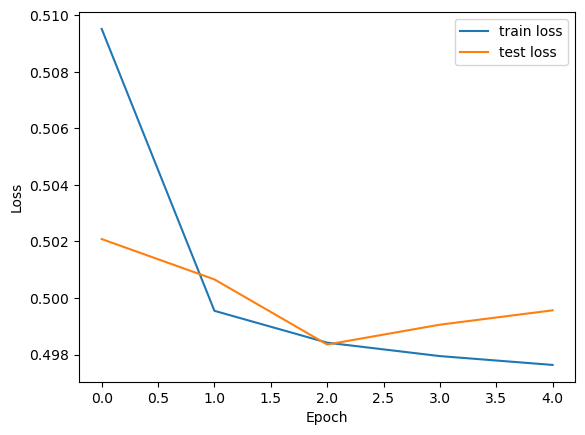

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot training and test loss
sns.lineplot(x=range(num_epochs), y=train_losses, label='train loss')
sns.lineplot(x=range(num_epochs), y=test_losses, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [37]:
#get error on training and test set
def getError(model, loader):
    error = 0
    model.eval()
    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        error += torch.sum(torch.abs(torch.round(output) - target)).item()
    return error/len(loader.dataset)

train_error = getError(model, train_loader)
test_error = getError(model, test_loader)
print('Training error: {}'.format(train_error))
print('Test error: {}'.format(test_error))

100%|██████████| 2327/2327 [00:06<00:00, 351.26it/s]

Training error: 0.22620268182937475
Test error: 0.22623300918712727


# first checks
bottlenecking the last 2 layers is fine

size_factor_hidden 10/20 no diff

data amount with 50000 results in low variance 

unavoidable error for samples that end up 50/50 in bound/unbound

-> change loss and label to frquencies in pools